# Pathological inputs

Testing attention patterns with various pathelogical inputs (e.g. random, repeated tokens, etc) to try and explore any interesting patterns generated.

In [1]:
import torch
from transformer_lens import HookedTransformer

torch.cuda.empty_cache()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from IPython.display import HTML
from circuitsvis.attention import attention_heads
from plotly import express as px
import plotly.io as pio
pio.renderers.default = "png"

def calculate_logit_diff(cache):
    pred_tokens = torch.tensor([
        [model.to_single_token(c) for c in completions] 
        for _, completions in cache.prompts
    ]).to(device)

    resid_directions = cache.model.tokens_to_residual_directions(pred_tokens)
    return resid_directions[:, 0] - resid_directions[:, 1]

def calculate_head_contribution(cache, towards, layer=-1, pos_slice=-1):
    per_head_residual = cache.stack_head_results(
        layer=layer, pos_slice=pos_slice,
    )

    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, towards,
    )

    return einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

def visualize_attention_patterns(heads, cache, token_labels=None):
    labels, patterns = [], []
    for head in heads:
        layer = head // cache.model.cfg.n_heads
        head_index = head % cache.model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(cache["attn", layer][0, head_index])

    patterns = torch.stack(patterns, dim=0)
    if token_labels is None:
        token_labels = [f"Token {i}" for i in range(cache['attn', 0].shape[-1])]

    return attention_heads(
        attention=patterns, tokens=token_labels, attention_head_names=labels
    ).show_code()

def generate_prompts(t):
    names = (" Mary", " John", " Alice")
    places = (" shops", " park", " beach")
    things = (" bag", " ball", " book")

    templates = [
        (
            t, (place, thing), permutations(names, 2),
        )
        for place, thing in product(places, things)
    ]

    return [
        (prompt.format(place, thing, S, IO), (IO, S))
        for prompt, (place, thing), names in templates
        for S, IO in names
    ]

### Random tokens

Input is generated by selecting 15 random tokens in a batch of 100 prompts. The attention head contributions are then plotted based on their contribution to a random token.

Tried to stack head results when they weren't cached. Computing head results now


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


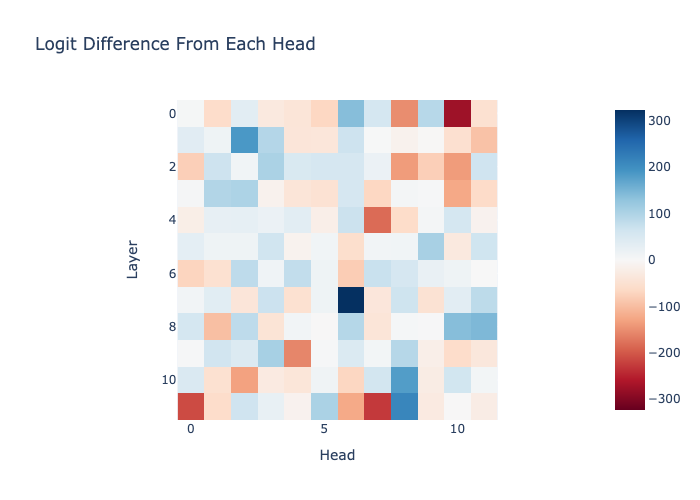

In [3]:
tokens = torch.randint(0, 50257, (100, 15)).to(device)
_, cache = model.run_with_cache(tokens)
random_token = torch.randint(0, 50257, (1, 1)).to(device)
random_token_direction = cache.model.tokens_to_residual_directions(random_token)
heads = calculate_head_contribution(cache, random_token_direction.unsqueeze(0))

px.imshow(
    heads.cpu(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    color_continuous_midpoint=0.0,
    color_continuous_scale="RdBu",
)

Plotting the attention patterns is interesting because some heads tend towards random noise (e.g. 0.0, 0.2, 0.6, etc) while others are in some kind of "default" state (e.g. 0.1, 0.3, 0.4, etc).

Perhaps this points to heads which focus, broadly, on token correlations and semantic structure respectively.

In [4]:
HTML(visualize_attention_patterns(range(144), cache))

### Random repeated token

Input is a batch of 100 random tokens, each repeated 15 times. The head contributions are plotted against the direction of the same random token.

Tried to stack head results when they weren't cached. Computing head results now


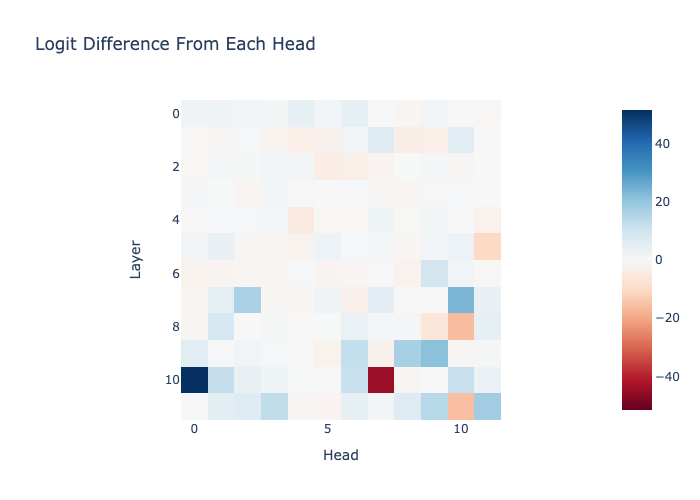

In [9]:
random_token = torch.randint(0, 50257, (1, 1)).to(device)
random_tokens = random_token.expand(-1, 15)
random_token_direction = cache.model.tokens_to_residual_directions(random_token[0])
_, cache = model.run_with_cache(random_tokens)
heads = calculate_head_contribution(cache, random_token_direction.unsqueeze(0))

px.imshow(
    heads.cpu(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    color_continuous_midpoint=0.0,
    color_continuous_scale="RdBu",
)

The attention patterns are what we'd expect to see if we make the assumption that heads learn via in-context learning - i.e. there are no patterns to capture other than the initial repeating token so we see smooth gradients with a few exceptions that quickly converge. 

4.11 is a notable exception.

In [10]:
HTML(visualize_attention_patterns(range(144), cache))

### Repeated random subsequence

Input is generated as a random 3 token sequence which is then repeated 5 times. Head attribution is plotted against the direction of the first token in the subsequence.

Tried to stack head results when they weren't cached. Computing head results now


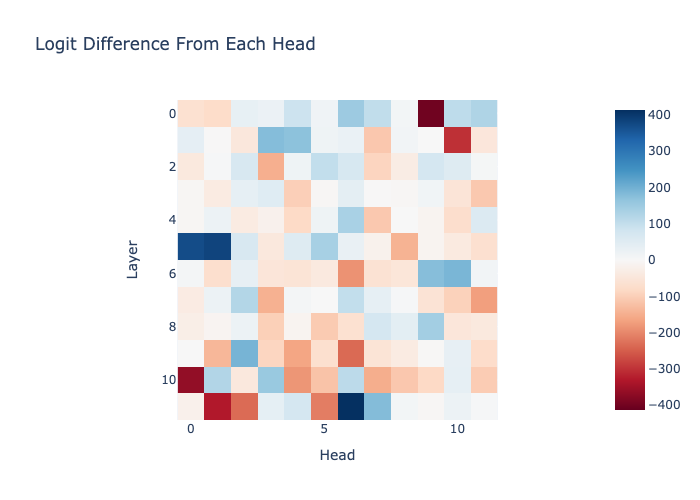

In [11]:
random_tokens = torch.randint(0, 50257, (100, 3)).to(device)
random_tokens = random_tokens.repeat(1, 5)
random_token = torch.randint(0, 50257, (1, 1)).to(device)
random_token_direction = cache.model.tokens_to_residual_directions(random_token)
_, cache = model.run_with_cache(random_tokens)
heads = calculate_head_contribution(cache, random_token_direction.unsqueeze(0))

fig = px.imshow(
    heads.cpu(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    color_continuous_midpoint=0.0,
    color_continuous_scale="RdBu",
)

fig

The attention patterns follow a similar pattern to the repeated token experiment in that smooth gradients represent repeating tokens, but this time for each token separately. This leads to some interesting properties that start to emerge as they intersect.

For example, the first head (0.0) attends to the input sequence depending on where the current token is in the subsequence. When the current token is A in the subsequence A, B, C it attends mostly to all previous C tokens, with scores ordered by most recent token. E.g. token 9 attends to 8, 5, 2 in that order.

In [12]:
HTML(visualize_attention_patterns(range(144), cache))